# Streamlit app dev and test

Work through code for the streamlist app

In [1]:
__author__      = 'Roy Gardner'

import networkx as nx
from networkx.readwrite import json_graph

import numpy as np
import matplotlib.pyplot as plt

import json
import os
import csv
import sys

import ipywidgets as widgets

from scipy.spatial.distance import *


twenty_distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0',\
                          '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8',\
                          '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff',\
                          '#000000']

def depth_first_search(matrix,query_index,max_depth=1,depth=1,vertices=[],visited=[]):
    """
    Recursive function to visit all vertices that are reachable from a query vertex.
    param matrix: The adjacency matrix representation of a graph
    param query_index: The row/column index which defines the query vertex
    param max_depth: How deep to go (for a bipartite graph the maximum is 2)
    param depth: Keeps track of how deep we have gone
    param vertices: Store found vertices
    param visited: Store visited vertices so we have a terminating condition
    return list of vertices
    """
    visited.append(query_index)
    # Index row - find connected head vertices in the query index row. In other words,
    # find the vertices that the query vertex point to
    vertices.extend([i for i,v in enumerate(matrix[query_index]) if v > 0 and not i in visited])
    if depth < max_depth:
        for i in vertices:
            if i in visited:
                continue
            vertices = depth_first_search(matrix,i,max_depth=1,depth=1,vertices=vertices,visited=visited)
    return vertices

def adjacency_from_biadjacency(pp_data_dict):
    """
    Build the full adjacency matrix from the binary part which represents bipartite 
    agreements-actor graph. The full adjacency is needed for DFS and by network packages.
    Rows and columns of the adjacency matrix are identical and
    are constructed from the binary-valued matrix in row-column order.
    The number of rows (and columns) in the adjacency matrix is therefore:
    binary_matix.shape[0] +  binary_matix.shape[1]
    param pp_data_dict: A dictionary containing peace process network data inclusing the BVRM
    return adjacency matrix and list of vertex labels. The latter is the concatenated lists of
    agreement and actor vertex labels
    """    
    binary_matrix = pp_data_dict['pp_matrix']
    size = binary_matrix.shape[0] + binary_matrix.shape[1]
    adjacency_matrix = np.zeros((size,size))
    
    # Get the range of the bin matrix rows to generate the upper triangle
    # of the adjacency matrix
    row_index = 0
    col_index = binary_matrix.shape[0]
    adjacency_matrix[row_index:row_index + binary_matrix.shape[0],\
           col_index:col_index + binary_matrix.shape[1]] = binary_matrix
    # Add in the lower triangle
    adjacency_matrix = adjacency_matrix + adjacency_matrix.T    
    adj_vertices = []
    adj_vertices.extend(pp_data_dict['pp_agreement_ids'])
    adj_vertices.extend(pp_data_dict['pp_actor_ids'])

    return adjacency_matrix,adj_vertices

def get_query_matrix(query_indices,matrix,max_depth=1,operator='OR'):    
    """
    Query an adjacency matrix using depth-first search
    param query_indices: The indices of the query vertices
    param matrix: The adjacency matrix we are querying
    param max_depth: Max depth of the search. Defaults to 1. Agreement-actor graphs are bipartite so
    the maximum depth is 2.
    param operator: Boolean operator to use on found vertices. AND restricts the results to entities
    that have an edge to all query vertices.
    return: An adjacency matrix for the set of found vertices and the indices of the found vertices
    """    
    found_indices = []
    for i,query_index in enumerate(query_indices):
        vertices = depth_first_search(matrix,query_index,max_depth=max_depth,vertices=[],visited=[])
        if i == 0:
            found_indices.extend(vertices)
        else:
            if operator == 'OR':
                found_indices = list(set(found_indices).union(set(vertices)))
            else:
                found_indices = list(set(found_indices).intersection(set(vertices)))
    # Add the query vertex to the found vertices
    found_indices.extend(query_indices)    
    found_indices = sorted(found_indices)
    # Extract the sub-matrix containing only the found vertices
    query_matrix = matrix[np.ix_(found_indices,found_indices)]
    return query_matrix,found_indices

def display_networkx_graph(query_matrix,vertex_indices,adj_vertices,data_dict):
    node_labels = {i:adj_vertices[index] for i,index in enumerate(vertex_indices)}
    node_colors = [data_dict['color_map'][v.split('_')[0]] for _,v in node_labels.items()]
    graph = nx.from_numpy_array(query_matrix, create_using=nx.Graph)
    f = plt.figure(figsize=(16,16))
    pos = nx.spring_layout(graph) 
    nx.draw_networkx(graph,pos,labels=node_labels,node_color=node_colors,node_size=200,alpha=0.6)
    plt.grid(False)
    plt.show()
    
def get_peace_processes(data_dict):
    """
    Get list of peace process names 
    param data_dict: The application's data dictionary obtained from load_agreement_actor_data()
    return: list of process names in alpha order
    """
    processes = [row[data_dict['links_header'].index('PPName')].strip() for row in data_dict['links_data']]
    return sorted(list(set(processes)))

def get_peace_process_data(process_name,data_dict):
    
    # Peace process data are in the links table so collect all edges assigned to the process
    pp_edges = [row for row in data_dict['links_data'] if row[data_dict['links_header'].\
                                                              index('PPName')].strip()==process_name]
    
    # Now we want the indices of peace process agreements and actors so we can extract the peace process
    # sub-matrix
    pp_agreement_ids = list(set([row[data_dict['links_header'].index('from_node_id')] for row in pp_edges]))
    pp_agreement_indices = [data_dict['agreement_vertices'].index(agreement_id) for\
                            agreement_id in pp_agreement_ids]
    
    pp_actor_ids = list(set([row[data_dict['links_header'].index('to_node_id')] for row in pp_edges]))
    pp_actor_indices = [data_dict['actor_vertices'].index(actor_id) for actor_id in pp_actor_ids]

    pp_matrix = data_dict['matrix'][np.ix_(pp_agreement_indices,pp_actor_indices)]
    pp_matrix = np.array(pp_matrix)
    pp_data_dict = {}
    pp_data_dict['pp_actor_ids'] = pp_actor_ids
    pp_data_dict['pp_agreement_ids'] = pp_agreement_ids
    pp_data_dict['pp_matrix'] = pp_matrix    
    return pp_data_dict

def get_cooccurrence_matrices(matrix):
    # Actor-actor co-occurence matrix for a peace process
    V = np.matmul(matrix.T,matrix)
    # Agreement-agreement co-occurence matrix
    W = np.matmul(matrix,matrix.T)
    return (V,W)

def load_agreement_actor_data(nodes_file,links_file,agreements_dict,data_path):
    # Stash data in a dictionary
    data_dict = {}
    
    # Read the CSVs
    with open(data_path + nodes_file, encoding='utf-8', errors='replace') as f:
        reader = csv.reader(f)
        # Get the header row
        nodes_header = next(reader)
        # Put the remaining rows into a list of lists
        nodes_data = [row for row in reader]

    with open(data_path + links_file, encoding='utf-8', errors='replace') as f:
        reader = csv.reader(f)
        # Get the header row
        links_header = next(reader)
        # Put the remaining rows into a list of lists
        links_data = [row for row in reader]

    with open(data_path + agreements_dict) as f:
        agreements_dict = json.load(f)
    
    # Agreement are from vertices
    agreement_vertices = list(set([row[links_header.index('from_node_id')] for row in links_data]))
    # Actors are to vertices
    actor_vertices = list(set([row[links_header.index('to_node_id')] for row in links_data]))

    edge_dict = {}
    dates_dict = {}
    for row in links_data:
        if row[5] in edge_dict:
            edge_dict[row[5]].append(row[12])
        else:
            edge_dict[row[5]] = [row[12]]
        if not row[5] in dates_dict:
            a = row[1].split('/')
            dates_dict[row[5]] = int(''.join(a[::-1]))
    
    # Build a vertices dictionary with node_id as key and node row as the value
    vertices_dict = {row[nodes_header.index('node_id')]:row for row in nodes_data}

    # Collect all vertex types
    vertex_types = []
    for k,v in vertices_dict.items():
        type_ = v[nodes_header.index('type')]
        if len(type_) == 0:
            # This type is missing in node data
            type_ = 'AGT'
        vertex_types.append(type_)
    vertex_types = sorted(list(set(vertex_types)))

    # Build a colour map for types
    color_map = {type_:twenty_distinct_colors[i] for\
                 i,type_ in enumerate(vertex_types)}
    
    # Build the agreement-actor BVRM matrix - the core data structure
    matrix = []
    for agreement in agreement_vertices:
        row = [0]*len(actor_vertices)
        for i,actor in enumerate(actor_vertices):
            if actor in edge_dict[agreement]:
                row[i] = 1
        matrix.append(row)
    matrix = np.array(matrix)
    
    data_dict['agreements_dict'] = agreements_dict
    data_dict['dates_dict'] = dates_dict
    data_dict['nodes_data'] = nodes_data
    data_dict['nodes_header'] = nodes_header
    data_dict['links_data'] = links_data
    data_dict['links_header'] = links_header
    data_dict['agreement_vertices'] = agreement_vertices
    data_dict['actor_vertices'] = actor_vertices
    data_dict['vertices_dict'] = vertices_dict
    data_dict['color_map'] = color_map
    data_dict['matrix'] = matrix

    return data_dict


## Load the agreement-actor data

- Load data into a binary-valued relation matrix (BVRM) with agreements in rows and actors in columns
- Matrix values are zero except where a relation between an agreement and an actor exists where the value is one
- Apart from the matrix other data are extracted or computed
- All data are stored in data_dict


In [2]:

data_path = './data/'
nodes_file = 'node_table.csv'
links_file = 'links_table.csv'
agreements_dict = 'agreements_dict.json'

data_dict = load_agreement_actor_data(nodes_file,links_file,agreements_dict,data_path)


## Get a peace process sub-matrix

- Create the binary-valued relation matrix containing only the agreements and actors of a defined peace process.
- Data are stored in pp_data_dict


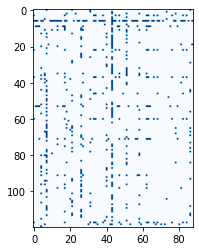

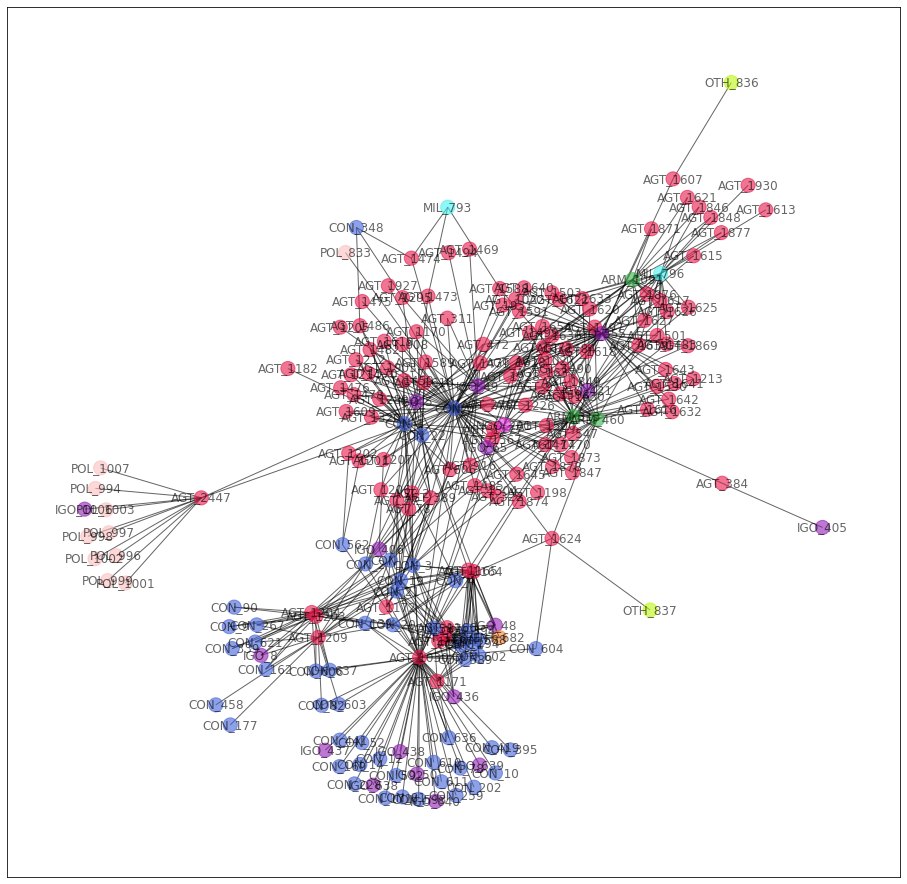

In [3]:

process_name = 'Bosnia peace process'
#process_name = 'Yemen peace process'
#process_name = 'Chad: Doha process'
#process_name = 'DRC: Eastern DRC processes'


pp_data_dict = get_peace_process_data(process_name,data_dict)
pp_matrix = pp_data_dict['pp_matrix']

plt.imshow(pp_matrix,cmap=plt.cm.Blues)
plt.show()

# Display graph
adj_matrix,adj_vertices = adjacency_from_biadjacency(pp_data_dict)
display_networkx_graph(adj_matrix,range(0,len(adj_vertices)),adj_vertices,data_dict)


## Extract values from data dictionaries

In [4]:
print(data_dict['vertices_dict']['CON_264'])
print(pp_data_dict['pp_actor_ids'])

['Actor', '264', 'CON', 'CON_264', 'Country/State', 'Congo, Democratic Republic of the', 'DRC', 'Congo, Democratic Republic of the', 'COD', '89.0', 'Government of DR Congo (Zaire)', 'Government of the Democratic Republic of Congo (2019-)', 'Government of the Democratic Republic of Congo (1997-2001) | Government of the Democratic Republic of Congo (2001-2019) | Government of the Democratic Republic of Congo (2019-)', 'Congo, Democratic Republic of (Zaire) | CONGO, THE DEMOCRATIC REPUBLIC OF | Democratic Republic | Democratic Republic Congo | Republic Democratic Republic Congo', 'Congo, Democratic Republic of the is a Country/State in Africa. ', '', '', '', '', '', '', '', '']
['CON_11', 'CON_606', 'CON_637', 'CON_267', 'IGO_49', 'IGO_438', 'IGO_5', 'IGO_355', 'OTH_837', 'CON_78', 'IGO_406', 'CON_14', 'CON_259', 'CON_7', 'CON_12', 'CON_228', 'CON_9', 'CON_3', 'NGO_201', 'OTH_836', 'CON_348', 'MIL_796', 'CON_611', 'POL_833', 'CON_419', 'CON_169', 'ARM_313', 'CON_2', 'IGO_50', 'IGO_437', '

In [ ]:
# Get actors in alpha order
actor_options = [(vertex_id,data_dict['vertices_dict'][vertex_id][5]) for vertex_id in\
                 pp_data_dict['pp_actor_ids']]
actor_options = sorted(actor_options,key=lambda t:t[1])
actor_options = [t[0] + ': ' + t[1] for t in actor_options]

# Get agreements in date order
agreement_options = [(vertex_id,data_dict['vertices_dict'][vertex_id][5],data_dict['dates_dict'][vertex_id])\
                     for vertex_id in pp_data_dict['pp_agreement_ids']]
agreement_options = sorted(agreement_options,key=lambda t:t[2])
agreement_options = [t[0] + ': ' + t[1] for t in agreement_options]


## Query peace process networks

### Query based on DFS in adjacency matrix

Notes:
- That depth 2 (and above) will yield the entire graph because the graph is bipartite.
- Should be either/or with respect to entity type.


In [ ]:

# Convert a peace process BVRM to an adjacency matrix
adj_matrix,adj_vertices = adjacency_from_biadjacency(pp_data_dict)

query_vertices = ['CON_19','CON_20','CON_21']
query_vertices = ['CON_20','CON_21']
query_vertices = ['CON_4','ARM_460']
#query_vertices = ['IGO_5','CON_20','CON_4']
#query_vertices = ['AGT_2447']
for vertex in query_vertices:
    print(vertex,data_dict['vertices_dict'][vertex][5])
print()

query_indices = [adj_vertices.index(vertex) for vertex in query_vertices]
query_matrix,found_indices = get_query_matrix(query_indices,adj_matrix,operator='OR')
display_networkx_graph(query_matrix,found_indices,adj_vertices,data_dict)


## Actor engagements over time in peace process

In [ ]:
#print(data_dict['dates_dict'])

#print(pp_data_dict['pp_agreement_ids'])
pp_ag_ids = pp_data_dict['pp_agreement_ids']

t_list = []
for i,agreement_id in enumerate(pp_ag_ids):
    if not agreement_id in data_dict['dates_dict']:
        continue
    ag_date = data_dict['dates_dict'][agreement_id]
    t_list.append((i,ag_date))
# Sort by date    
t_list = sorted(t_list,key=lambda t:t[1])
    
# Build a time-order agreement-actor matrix
ordered_matrix = []
for t in t_list:
    ordered_matrix.append(pp_data_dict['pp_matrix'][t[0]])
    
ordered_matrix = np.array(ordered_matrix)
# Put actors in rows
ordered_matrix = ordered_matrix.T

# Now order actors by first appearance in process
row_indices = []
for i,row in enumerate(ordered_matrix):
    where = np.where(row==1)
    v = 0
    if len(where[0]) > 0:
        v = where[0][0]
    row_indices.append((i,v))
sorted_row_indices = [t[0] for t in sorted(row_indices,key=lambda t:t[1])]

sorted_matrix = ordered_matrix[np.ix_(sorted_row_indices)]

f = plt.figure(figsize=(16,8))
for i,row in enumerate(sorted_matrix):
    x = [j for j,x in enumerate(row) if x > 0]
    y = [i]*len(x)
    plt.scatter(x,y,alpha=0.9,linewidth=0.5,s=10)
    plt.plot(x,y,alpha=0.9,linewidth=0.5)
plt.xticks(fontsize='xx-large')    
plt.yticks(fontsize='xx-large')    
plt.ylabel('Actor index (in order of first appearance)',fontsize='xx-large')
plt.xlabel('Agreement index in time order',fontsize='xx-large')
plt.show()

print(sorted_row_indices)
print(data_dict['vertices_dict'][pp_data_dict['pp_actor_ids'][4]][5])


## Build an actor-year matrix

In [ ]:
labels = [data_dict['vertices_dict'][v][5] for v in pp_data_dict['pp_actor_ids']]
z = list(zip(range(0,len(labels)),labels))
z = sorted(z,key=lambda t:t[1])

# Get a sorted list of years

pp_ag_ids = pp_data_dict['pp_agreement_ids']

year_list = []
for i,agreement_id in enumerate(pp_ag_ids):
    if not agreement_id in data_dict['dates_dict']:
        continue
    ag_year = int(str(data_dict['dates_dict'][agreement_id])[0:4])
    year_list.append(ag_year)
# Sort by year    
year_list = sorted(set(year_list))
print(year_list)

year_matrix = np.zeros((len(pp_data_dict['pp_actor_ids']),len(year_list)))

matrix_t = pp_data_dict['pp_matrix'].T
for i,row in enumerate(matrix_t):
    for j,v in enumerate(row):
        if v == 0:
            continue
        agreement_id = pp_data_dict['pp_agreement_ids'][j]
        year = int(str(data_dict['dates_dict'][agreement_id])[0:4])
        year_index = year_list.index(year)
        year_matrix[i][year_index] += 1
        
# Get matrix in actor alpha order
ordered_year_matrix = []
for t in z:
    ordered_year_matrix.append(year_matrix[t[0]])
    
ordered_year_matrix = np.array(ordered_year_matrix)
        
        
fig = plt.figure(figsize=(16,16),layout="constrained")
plt.imshow(ordered_year_matrix,aspect='auto',cmap=plt.cm.Blues)
plt.xticks(range(0,len(year_list)),year_list)
plt.yticks(range(0,len(labels)),[t[1] for t in z])
cbar = plt.colorbar()
cbar.set_label('Signed in year',rotation=270,labelpad=15,fontsize='x-large')
plt.show()


## Compute co-occurence matrices

Paths of length 2 between actors

Use a peace process binary-valued relation matrix to compute co-occurences:
- For a pair of actors, the number of agreements in common
- For a pair of agreements, the number of actors in common


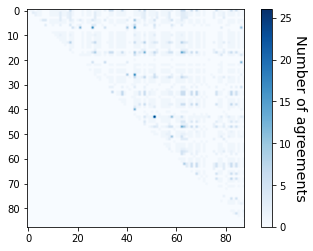

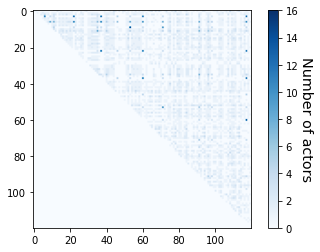

Actors who are co-signatories to the greatest number of agreements: Bosnia and Herzegovina (CON_0) and Croatia (CON_1)
Number of agreements: 26

Agreements with the greatest number of co-signatories: UN Security Council Resolution 1035 (AGT_1204) and UN Security Council Resolution 1031 (AGT_1203)
Number of co-signatories: 16



In [5]:
co_matrices = get_cooccurrence_matrices(pp_data_dict['pp_matrix'])
actor_upper = np.triu(co_matrices[0],k=1)
agreement_upper = np.triu(co_matrices[1],k=1)

plt.imshow(actor_upper,cmap=plt.cm.Blues)
cbar = plt.colorbar()
cbar.set_label('Number of agreements',rotation=270,labelpad=15,fontsize='x-large')
plt.show()

plt.imshow(agreement_upper,cmap=plt.cm.Blues)
cbar = plt.colorbar()
cbar.set_label('Number of actors',rotation=270,labelpad=15,fontsize='x-large')
plt.show()

# Actors with max agreements between them
indices = np.unravel_index(np.argmax(actor_upper,axis=None),actor_upper.shape)
actors = [(pp_data_dict['pp_actor_ids'][index],\
           data_dict['vertices_dict'][pp_data_dict['pp_actor_ids'][index]][5]) for index in indices]
s = actors[0][1] + ' (' + actors[0][0] + ') and ' + actors[1][1] + ' (' + actors[1][0] + ')'
print('Actors who are co-signatories to the greatest number of agreements:',s)
print('Number of agreements:',actor_upper[indices])
print()

# Agreements with max actors between them
indices = np.unravel_index(np.argmax(agreement_upper,axis=None),agreement_upper.shape)
agreements = [(pp_data_dict['pp_agreement_ids'][index],\
               data_dict['vertices_dict'][pp_data_dict['pp_agreement_ids'][index]][5]) for index in indices]
s = agreements[0][1] + ' (' + agreements[0][0] + ') and ' + agreements[1][1] + ' (' + agreements[1][0] + ')'
print('Agreements with the greatest number of co-signatories:',s)
print('Number of co-signatories:',agreement_upper[indices])
print()



In [12]:
print(data_dict['nodes_header'])

['overall_node_type', 'id', 'type', 'node_id', 'node_type', 'node_name', 'abbreviation', 'country_based', 'node_country', 'ucdp_id', 'in_ucdp', 'acled_name', 'acled_other', 'alternative_names', 'description', 'date', 'year', 'month', 'day', 'month_full', 'PP', 'PPName', 'Loc2ISO']


## Retrieving co-occurrence entities


In [17]:
def get_agreement_cosignatories(agreement_ids,pp_data_dict):
    # Given a list of agreements get the actors in common
    if len(agreement_ids) < 2:        
        return []
    for agreement_id in agreement_ids:
        if not agreement_id in pp_data_dict['pp_agreement_ids']:
            return []
    agreement_indices = [pp_data_dict['pp_agreement_ids'].index(agreement_id) for\
                         agreement_id in agreement_ids]
    for i,agreement_index in enumerate(agreement_indices):
        row = pp_data_dict['pp_matrix'][agreement_index]
        if i == 0:
            actors_bitset = row
        else:
            actors_bitset = np.bitwise_and(actors_bitset,row)
    actor_ids = []
    for index,value in enumerate(actors_bitset): 
        if value == 1:
            actor_ids.append(pp_data_dict['pp_actor_ids'][index])
    return actor_ids

def get_consignatory_agreements(actor_ids,pp_data_dict):
    # Given a list of actors get the agreements in common
    if len(actor_ids) < 2:        
        return []
    for actor_id in actor_ids:
        if not actor_id in pp_data_dict['pp_actor_ids']:
            return []
    actor_indices = [pp_data_dict['pp_actor_ids'].index(actor_id) for actor_id in actor_ids]
    for i,actor_index in enumerate(actor_indices):
        row = pp_data_dict['pp_matrix'].T[actor_index]
        if i == 0:
            agreements_bitset = row
        else:
            agreements_bitset = np.bitwise_and(agreements_bitset,row)
    agreement_ids = []
    for index,value in enumerate(agreements_bitset): 
        if value == 1:
            agreement_ids.append(pp_data_dict['pp_agreement_ids'][index])
    return agreement_ids

def get_consignatories(actor_id,pp_data_dict):
    # Peace process cosignatories of a given agreement
    co_matrices = get_cooccurrence_matrices(pp_data_dict['pp_matrix'])
    actor_index = pp_data_dict['pp_actor_ids'].index(actor_id)
    cosign_ids = [pp_data_dict['pp_actor_ids'][i] for i,v in enumerate(co_matrices[0][actor_index]) if v > 0]
    return cosign_ids

def get_coagreements(agreement_id,pp_data_dict):
    # Peace process agreements with signatories in common
    co_matrices = get_cooccurrence_matrices(pp_data_dict['pp_matrix'])
    agreement_index = pp_data_dict['pp_agreement_ids'].index(agreement_id)
    coagree_ids = [pp_data_dict['pp_agreement_ids'][i] for\
                   i,v in enumerate(co_matrices[1][agreement_index]) if v > 0]
    return coagree_ids

def get_agreements(actor_id,pp_data_dict):
    # Peace process agreements for an actor
    actor_index = pp_data_dict['pp_actor_ids'].index(actor_id)
    agreement_ids = [pp_data_dict['pp_agreement_ids'][i] for\
                     i,v in enumerate(pp_data_dict['pp_matrix'][:,actor_index]) if v > 0]
    return agreement_ids

def get_actors(agreement_id,pp_data_dict):
    # Peace process actors for an agreement 
    agreement_index = pp_data_dict['pp_agreement_ids'].index(agreement_id)
    actor_ids = [pp_data_dict['pp_actor_ids'][i] for\
                     i,v in enumerate(pp_data_dict['pp_matrix'][agreement_index]) if v > 0]
    return actor_ids

def get_actor_name(actor_id,data_dict):
    return data_dict['vertices_dict'][actor_id][data_dict['nodes_header'].index('node_name')]

def get_agreement_name(agreement_id,data_dict):
    return data_dict['vertices_dict'][agreement_id][data_dict['nodes_header'].index('node_name')]

actor = 'CON_4'
print('Agreements signed by',actor,get_actor_name(actor,data_dict))
agreements = get_agreements(actor,pp_data_dict)
tuples = [(agreement,get_agreement_name(agreement,data_dict)) for agreement in agreements]
tuples = sorted(tuples,key=lambda t:t[1])
for t in tuples:
    print(t[0],t[1])
print()

print('Cosignatories of',actor,get_actor_name(actor,data_dict))
cosigns = get_consignatories(actor,pp_data_dict)
tuples = [(cosign,get_actor_name(cosign,data_dict)) for cosign in cosigns]
tuples = sorted(tuples,key=lambda t:t[1])
for t in tuples:
    print(t[0],t[1])
print()

print('Cosignatories of',actor,'organised by agreement')
agreement_cosign_dict = {}
for cosign in cosigns:
    agreements = get_consignatory_agreements([actor,cosign],pp_data_dict)
    for agreement in agreements:
        if agreement in agreement_cosign_dict:
            agreement_cosign_dict[agreement].append(cosign)
        else:
            agreement_cosign_dict[agreement] = [cosign]
for agreement,actors in agreement_cosign_dict.items():
    print(agreement)
    print(actors)
    print()
print()

agreement = 'AGT_1624'
print('Signatories of agreement',agreement)
print(get_actors(agreement,pp_data_dict))
print()

print('Agreements with signatories in common with',agreement)
coagrees = get_coagreements(agreement,pp_data_dict)
print(coagrees)    
print()

print('Agreements with signatories in common with',agreement,'organised by cosignatory')
cosign_agreement_dict = {}
for coagree in coagrees:
    cosignatories = get_agreement_cosignatories([agreement,coagree],pp_data_dict)
    for cosign in cosignatories:
        if cosign in cosign_agreement_dict:
            cosign_agreement_dict[cosign].append(coagree)
        else:
            cosign_agreement_dict[cosign] = [coagree]
for cosign,agreements in cosign_agreement_dict.items():
    print(cosign)
    print(agreements)
    print()
print()



Agreements signed by CON_4 Spain
AGT_1030 Conclusions of the Peace Implementation Conference held at Lancaster House (London Conference)
AGT_2 Dayton Agreement on Implementing the Federation of Bosnia and Herzegovina, Dayton
AGT_1624 Medjugorje Agreement 
AGT_1172 Text of US/Russia/UK/France/Spain Joint Action Programme (JAP) on Bosnia

Cosignatories of CON_4 Spain
CON_587 Albania
CON_588 Austria
CON_441 Belgium
CON_0 Bosnia and Herzegovina
CON_589 Bulgaria
CON_11 Canada
CON_20 China
IGO_639 Council of Europe
CON_1 Croatia
ARM_460 Croatian Republic of Herzeg-Bosnia
CON_637 Czechia
CON_604 Denmark
CON_82 Egypt
IGO_638 European Bank for Reconstruction and Development
IGO_436 European Commission
IGO_5 European Union
CON_171 Finland
CON_7 France
CON_2 Germany
CON_636 Greece
IGO_65 High Commission for Refugees
CON_602 Hungary
NGO_201 International Committee of the Red Cross
OTH_837 International Conference on the Former Yugoslavia
IGO_438 International Monetary Fund
CON_169 Ireland
CON_139 

In [ ]:

co_matrices = get_cooccurrence_matrices(pp_data_dict['pp_matrix'])
#print(list(co_matrices[0]))

# Find agreements that a pair of actors have in common
# Define indices for a pair of actors

actors = ['CON_20','CON_21']
actor_indices = [pp_data_dict['pp_actor_ids'].index(actor_id) for actor_id in actors]

# Number in co-occurrence cell
print(co_matrices[0][actor_indices[0]][actor_indices[1]])

# Get the row from the transpose of pp matrix
row1 = pp_data_dict['pp_matrix'].T[actor_indices[0]]
# Get the row from the pp matrix
row2 = pp_data_dict['pp_matrix'].T[actor_indices[1]]


x = np.bitwise_and(row1,row2)


#print(len(x)) # The number of agreements

for index,value in enumerate(x): 
    if value == 1:
        print(pp_data_dict['pp_agreement_ids'][index],\
              data_dict['vertices_dict'][pp_data_dict['pp_agreement_ids'][index]][5])


## Paths of length 4 

Bipartite equivalent of friend-of-a-friend. A path 4 between two actors who are not cosignatories, means there's another actor who is a cosignatory to the agreements of both actors. Therefore the mediating actor is a cosignatory with both path 4 actors, i.e., the intersection of the actor cosignatory sets.


In [ ]:
co_matrices = get_cooccurrence_matrices(pp_data_dict['pp_matrix'])

actor_2_paths = co_matrices[0]
actor_4_paths = np.linalg.matrix_power(actor_2_paths,2)

actor_2_paths[actor_2_paths != 0] = 1
actor_4_paths[actor_4_paths != 0] = 1

co_matrices = get_cooccurrence_matrices(pp_data_dict['pp_matrix'])
# Remove all actors with a path 2 
U = np.linalg.matrix_power(co_matrices[0],2) * np.bitwise_xor(actor_2_paths,actor_4_paths)

upper = np.triu(U,k=1)
plt.imshow(upper,cmap=plt.cm.Blues)
cbar = plt.colorbar()
cbar.set_label('Number of actors',rotation=270,labelpad=15,fontsize='x-large')
plt.show()

print(np.argmax(upper,axis=None))
actor_indices = np.unravel_index(np.argmax(upper,axis=None),upper.shape)
actors = [(pp_data_dict['pp_actor_ids'][index],\
           data_dict['vertices_dict'][pp_data_dict['pp_actor_ids'][index]][5]) for index in actor_indices]
print(actors)

cosigns1 = get_consignatories('CON_1',pp_data_dict)
print(sorted(cosigns1))
print()

cosigns2 = get_consignatories('ARM_460',pp_data_dict)
print(sorted(cosigns2))
print()

print(sorted(list(set(cosigns1).intersection(cosigns2))))


## Actor diagonal by stage

In [ ]:
stage_dict = {}
stage_dict['Cea'] = [1,'Ceasefire related']
stage_dict['Pre'] = [2,'Pre-negotiation process']
stage_dict['SubPar'] = [3,'Partial Framework - substantive']
stage_dict['SubComp'] = [4,'Comprehensive Framework - substantive']
stage_dict['Ren'] = [5,'Implementation Renegotiation/Renewal']
stage_dict['Imp'] = [5,'Implementation Renegotiation/Renewal']
stage_dict['Oth'] = [0,'']

# Map agreements on to stages
stage_map = {}
for i,agreement_id in enumerate(pp_data_dict['pp_agreement_ids']):
    ss_id = agreement_id.split('_')[1]
    if ss_id in data_dict['agreements_dict']:
        stage_map[i] = stage_dict[data_dict['agreements_dict'][ss_id]['Stage']][0]
    else:
        stage_map[i] = 0
    
print(len(stage_map))
print(len(pp_data_dict['pp_agreement_ids']))

print(len([v for _,v in stage_map.items() if v == 0]))


In [ ]:
from matplotlib.gridspec import GridSpec


co_matrices = get_cooccurrence_matrices(pp_data_dict['pp_matrix'])
actor_diag = np.diag(co_matrices[0])

# Plot

labels = [data_dict['vertices_dict'][v][5] for v in pp_data_dict['pp_actor_ids']]
z = list(zip(labels,actor_diag))
z = sorted(z,key=lambda t:t[1])
values = [t[1] for t in z]
        
        
fig = plt.figure(figsize=(16,16),layout="constrained")

gs = GridSpec(1, 6, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax1.barh(range(0,len(actor_diag)),values)
ax1.set_yticks(range(0,len(actor_diag)),[t[0] for t in z],fontsize='large')
ax1.set_xlim(0,max(values)+5)
ax1.margins(y=0)
ax1.set_title('All Stages',fontsize='xx-large')

print(z)
print()

stage_levels = [1,2,3,4,5]
for i,stage_level in enumerate(stage_levels):
    stage_agreement_indices = [k for k,v in stage_map.items() if v == stage_level]

    stage_matrix = pp_data_dict['pp_matrix'][np.ix_(stage_agreement_indices)]

    co_matrices = get_cooccurrence_matrices(stage_matrix)
    
    # Same order as all agreements so y-axes are consistent
    actor_diag = np.diag(co_matrices[0])
    x = list(zip(labels,actor_diag))
    x = sorted(x,key=lambda t:[g[0] for g in z].index(t[0]))
    #print(x)
    print()
    
    ax = fig.add_subplot(gs[0,i+1])
    ax.barh(range(0,len(actor_diag)),[t[1] for t in x])

    ax.set_yticks([],[])
    ax.set_xlim(0,max(values)+5)
    ax.margins(y=0)
    ax.set_title('Level ' + str(stage_level),fontsize='xx-large')


fig.suptitle('Actor Signatory Counts by Agreement Stage',fontsize='xx-large')

plt.show()

In [ ]:
co_matrices = get_cooccurrence_matrices(pp_data_dict['pp_matrix'])
actor_diag = np.diag(co_matrices[0])

# Plot

labels = [data_dict['vertices_dict'][v][5] for v in pp_data_dict['pp_actor_ids']]
z = list(zip(labels,actor_diag))
z = sorted(z,key=lambda t:t[1])
print(len(z))

f = plt.figure(figsize=(8,32))
plt.barh(range(0,len(actor_diag)),[t[1] for t in z])
plt.yticks(range(0,len(actor_diag)),[t[0] for t in z],fontsize='large')
plt.xlabel('Number of agreements to which actor is signatory')
plt.show()


## Build process-actor matrix

In [ ]:
# Build a peace process-actor matrix

data_path = './data/'
nodes_file = 'node_table.csv'
links_file = 'links_table.csv'
agreements_dict = 'agreements_dict.json'

data_dict = load_agreement_actor_data(nodes_file,links_file,agreements_dict,data_path)

# Get list of peace processes
processes = get_peace_processes(data_dict)


process_matrix = np.zeros((len(processes),len(data_dict['actor_vertices'])), dtype=int)

for i,process_name in enumerate(processes):
    process_data = get_peace_process_data(process_name,data_dict)
    actor_marginal = [sum(row) for row in process_data['pp_matrix'].T]
    actor_indices = [data_dict['actor_vertices'].index(actor_id) for actor_id in process_data['pp_actor_ids']]
    for j,v in enumerate(actor_marginal):
        if v > 0:
            process_matrix[i][actor_indices[j]] = 1

plt.imshow(process_matrix,cmap=plt.cm.Blues,aspect='auto')

proc_co = get_cooccurrence_matrices(process_matrix)



In [ ]:


data_path = './data/'
nodes_file = 'node_table.csv'
links_file = 'links_table.csv'
agreements_dict = 'agreements_dict.json'

data_dict = load_agreement_actor_data(nodes_file,links_file,agreements_dict,data_path)
matrix = data_dict['matrix']


# Matrix plot routines
print(matrix.shape)
f = plt.figure(figsize=(32,32))
plt.imshow(complete_matrix,aspect='auto')
plt.show()

# Get the column marginals
col_marginals = []
for row in complete_matrix.T:
    col_marginals.append(sum(row))


plt.plot(range(0,len(col_marginals)),col_marginals)
plt.show()

max_i = col_marginals.index(max(col_marginals))
max_actor = to_vertices[max_i]
print(max_actor,vertices_dict[max_actor][5])


In [ ]:
x = np.argsort(col_marginals)[::-1][:5]
print("Indices:",x)
